In [1]:
# !pip install -U tensorflow==2.11.1
# !pip install -U tensorflow_io==0.28.0

In [2]:
import os
from os import listdir
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import librosa
import scipy.io.wavfile as wavfile
import soundfile as sf
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **DATASET**

In [3]:
audio_dir = '/kaggle/input/asvspoof-la-reduced/reduced_LA/reduced_LA/flac/'
metadata = pd.read_csv('/kaggle/input/asvspoof-la-reduced/reduced_LA/reduced_LA/modified_1500.csv')
metadata.head()

,speaker_ID,audio_ID,codec,transmission_geo,spoof_type,target,trim_status,subset,gender
0,LA_0009,LA_E_9332881,alaw,ita_tx,A07,spoof,notrim,eval,female
1,LA_0009,LA_E_6866159,alaw,ita_tx,A07,spoof,notrim,eval,female
2,LA_0009,LA_E_4759417,alaw,sin_tx,A07,spoof,notrim,eval,female
3,LA_0009,LA_E_2667748,alaw,loc_tx,A07,spoof,notrim,eval,female
4,LA_0009,LA_E_8589971,alaw,loc_tx,A07,spoof,notrim,progress,female


In [4]:
#Filter the data
my_classes = ['bonafide', 'spoof']
map_class_to_id = {'bonafide': 0, 'spoof': 1}
map_spoof_type_to_id = {'A07':1, 'A08':2, 'A09':3, 'A10':4, 'A11':5, 'A12':6,'A13':7,'A14':8,'A15':9,'A16':10,'A17':11,'A18':12,'A19':13,'bonafide':14}
class_id = metadata['target'].apply(lambda name: map_class_to_id[name])
metadata['target_val'] = class_id

spoof_id = metadata['spoof_type'].apply(lambda name: map_spoof_type_to_id[name])
metadata['spoof_val'] = spoof_id

full_path = metadata['audio_ID'].apply(lambda row: os.path.join(audio_dir,row+'.flac'))
metadata['audio_path'] = full_path

metadata.head()

,speaker_ID,audio_ID,codec,transmission_geo,spoof_type,target,trim_status,subset,gender,target_val,spoof_val,audio_path
0,LA_0009,LA_E_9332881,alaw,ita_tx,A07,spoof,notrim,eval,female,1,1,/kaggle/input/asvspoof-la-reduced/reduced_LA/r...
1,LA_0009,LA_E_6866159,alaw,ita_tx,A07,spoof,notrim,eval,female,1,1,/kaggle/input/asvspoof-la-reduced/reduced_LA/r...
2,LA_0009,LA_E_4759417,alaw,sin_tx,A07,spoof,notrim,eval,female,1,1,/kaggle/input/asvspoof-la-reduced/reduced_LA/r...
3,LA_0009,LA_E_2667748,alaw,loc_tx,A07,spoof,notrim,eval,female,1,1,/kaggle/input/asvspoof-la-reduced/reduced_LA/r...
4,LA_0009,LA_E_8589971,alaw,loc_tx,A07,spoof,notrim,progress,female,1,1,/kaggle/input/asvspoof-la-reduced/reduced_LA/r...


In [5]:
metadata = metadata[['audio_path','target_val','spoof_val']]
metadata.head()

,audio_path,target_val,spoof_val
0,/kaggle/input/asvspoof-la-reduced/reduced_LA/r...,1,1
1,/kaggle/input/asvspoof-la-reduced/reduced_LA/r...,1,1
2,/kaggle/input/asvspoof-la-reduced/reduced_LA/r...,1,1
3,/kaggle/input/asvspoof-la-reduced/reduced_LA/r...,1,1
4,/kaggle/input/asvspoof-la-reduced/reduced_LA/r...,1,1


In [6]:
augmented_dir = '/kaggle/input/asvspoof-la-reduced/flac_augmented_bonafide/flac_augmented_bonafide/'
augmented_files = os.listdir(path='/kaggle/input/asvspoof-la-reduced/flac_augmented_bonafide/flac_augmented_bonafide/')

In [7]:
augmented_path = map(lambda x: os.path.join(augmented_dir,x), augmented_files)
augmented_pd=pd.DataFrame({
    'audio_path' : augmented_path,
    'target_val' : [map_class_to_id['bonafide']]*len(augmented_files),
    'spoof_val' : [map_spoof_type_to_id['bonafide']]*len(augmented_files)
})
augmented_pd.head()

,audio_path,target_val,spoof_val
0,/kaggle/input/asvspoof-la-reduced/flac_augment...,0,14
1,/kaggle/input/asvspoof-la-reduced/flac_augment...,0,14
2,/kaggle/input/asvspoof-la-reduced/flac_augment...,0,14
3,/kaggle/input/asvspoof-la-reduced/flac_augment...,0,14
4,/kaggle/input/asvspoof-la-reduced/flac_augment...,0,14


In [8]:
metadata = pd.concat([metadata, augmented_pd], axis=0, ignore_index = True)

In [9]:
metadata['target_val'].value_counts()

target_val
0    72740
1    70584
Name: count, dtype: int64

In [10]:
metadata['spoof_val'].value_counts()

spoof_val
14    72740
10     5775
8      5774
9      5651
13     5626
11     5606
12     5460
6      5456
7      5438
2      5256
5      5219
4      5194
3      5122
1      5007
Name: count, dtype: int64

In [11]:
del augmented_pd
del augmented_files
del augmented_path

# PREPROCESSING

In [12]:
metadata = metadata.sample(frac=1, random_state=42).reset_index(drop=True)

filenames = metadata['audio_path']
targets = metadata['target_val']
spoof_type = metadata['spoof_val']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets,spoof_type,filenames))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [13]:
# filenames.duplicated().sum()

In [15]:
testing_flac_file_name = '/kaggle/input/asvspoof-la-reduced/reduced_LA/reduced_LA/flac/LA_E_1001118.flac'
print(testing_flac_file_name)

display.Audio(testing_flac_file_name, rate=16000)

/kaggle/input/asvspoof-la-reduced/reduced_LA/reduced_LA/flac/LA_E_1001118.flac


In [18]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_flac_16k_mono(filename,sample_rate=16000):
    """ Load a FLAC file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    with tf.device('/CPU:0'):
      file_contents = tf.io.read_file(filename)
      audio = tfio.audio.decode_flac(file_contents,dtype=tf.int16)
      audio = tf.squeeze(audio, axis=-1)
      audio = tf.cast(audio, dtype=tf.float32)
      audio = tfio.audio.resample(audio, rate_in=sample_rate, rate_out=16000)
      
    return audio

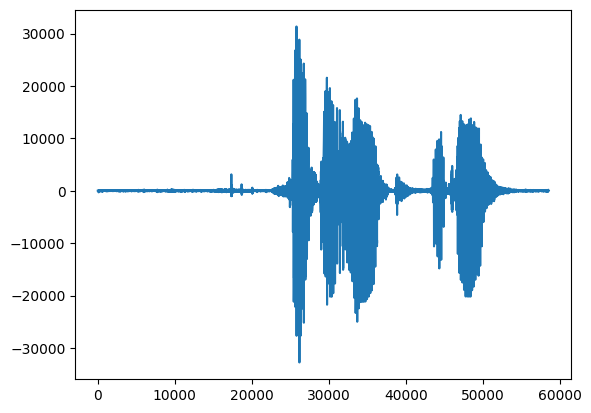

In [19]:
testing_flac_data = load_flac_16k_mono(testing_flac_file_name)

_ = plt.plot(testing_flac_data)

display.Audio(testing_flac_data, rate=16000)

In [20]:
print(testing_flac_data)
audio_length = tf.shape(testing_flac_data)[0]
sample_rate = 16000
duration_seconds = audio_length / sample_rate
print("Audio duration (seconds):", duration_seconds)

tf.Tensor(
[ 4.6285666e-05 -1.1501819e-04  2.6014319e-04 ... -8.2308273e+00
 -1.0768713e+01 -1.9230953e+01], shape=(58560,), dtype=float32)
Audio duration (seconds): tf.Tensor(3.66, shape=(), dtype=float64)


# LOAD YAMNET

In [21]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [22]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:10]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
...


In [27]:
def load_aud_for_map(filename, label, spoof_type, filenames):
  return load_flac_16k_mono(filename), label, spoof_type, filenames

main_ds = main_ds.map(load_aud_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [28]:
# applies the embedding extraction model to a wav data
def extract_embedding(aud_data, label, spoof_type, filename):
  ''' run YAMNet to extract embedding from the audio data '''
  scores, embeddings, spectrogram = yamnet_model(aud_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(spoof_type, num_embeddings),
            tf.repeat(filename, num_embeddings))
  
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

# SPLIT THE DATA

In [32]:
# split using StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

for train_index, remaining_index in stratified_split.split(filenames, targets):
    strat_train_indices = train_index
    remaining_indices = remaining_index

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in stratified_split.split(remaining_indices, targets.iloc[remaining_indices]):
    strat_val_indices = val_index
    strat_test_indices = test_index

train_ds = main_ds.enumerate().filter(lambda i, _: tf.reduce_any(tf.equal(i, strat_train_indices))).map(lambda i, data: data)
val_ds = main_ds.enumerate().filter(lambda i, _: tf.reduce_any(tf.equal(i, strat_val_indices))).map(lambda i, data: data)
test_ds = main_ds.enumerate().filter(lambda i, _: tf.reduce_any(tf.equal(i, strat_test_indices))).map(lambda i, data: data)

remove_filename = lambda embedding, label, spoof_type, filename: (embedding, label)

train_ds = train_ds.map(remove_filename)
val_ds = val_ds.map(remove_filename)
test_ds = test_ds.map(remove_filename)


In [34]:
##split stratified by spoof_type
# from sklearn.model_selection import train_test_split

# stratify_labels = tf.stack([targets, spoof_type], axis=1)

# strat_train_indices, strat_remaining_indices = train_test_split(
#     np.arange(len(filenames)), test_size=0.4, random_state=42, stratify=stratify_labels)

# strat_val_indices, strat_test_indices = train_test_split(
#     strat_remaining_indices, test_size=0.5, random_state=42)

# train_indices = strat_train_indices
# val_indices = strat_val_indices
# test_indices = strat_test_indices

# train_ds = main_ds.enumerate().filter(lambda i, _: tf.reduce_any(tf.equal(i, train_indices))).map(lambda i, data: data)
# val_ds = main_ds.enumerate().filter(lambda i, _: tf.reduce_any(tf.equal(i, val_indices))).map(lambda i, data: data)
# test_ds = main_ds.enumerate().filter(lambda i, _: tf.reduce_any(tf.equal(i, test_indices))).map(lambda i, data: data)

# remove_columns = lambda embedding, label, spoof_type, filename: (embedding, label)

# train_ds = train_ds.map(remove_columns)
# val_ds = val_ds.map(remove_columns)
# test_ds = test_ds.map(remove_columns)



In [35]:
# Cache, shuffle, batch, and prefetch the datasets
train_ds = train_ds.shuffle(85994).cache().batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)


In [38]:
print(len(strat_train_indices))
print(len(strat_val_indices))
print(len(strat_test_indices))

85994
28665
28665


In [39]:
train_ds.element_spec

(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [40]:
#checking number of spoof and bonafide in train_ds
vals = np.concatenate([t.numpy() for _, t in train_ds])
print(np.unique(vals))
print(np.count_nonzero(vals == 1))
print(vals.size - np.count_nonzero(vals))

[0 1]
31368
54626


In [41]:
#checking number of spoof and bonafide in val_ds
vals = np.concatenate([t.numpy() for _, t in val_ds])
print(np.unique(vals))
print(np.count_nonzero(vals == 1))
print(vals.size - np.count_nonzero(vals))

[0 1]
10382
18283


In [42]:
#checking number of spoof and bonafide in test_ds
vals = np.concatenate([t.numpy() for _, t in test_ds])
print(np.unique(vals))
print(np.count_nonzero(vals == 1))
print(vals.size - np.count_nonzero(vals))

[0 1]
10605
18060


# MODEL

In [48]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [49]:
tf.__version__

'2.11.1'

In [50]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
]

In [51]:
history = my_model.fit(train_ds,
                       epochs=500,
                       batch_size =32,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/500
2688/2688 [==============================] - 23s 8ms/step - loss: 0.6841 - accuracy: 0.7816 - val_loss: 0.4028 - val_accuracy: 0.8138
Epoch 2/500
2688/2688 [==============================] - 20s 7ms/step - loss: 0.3972 - accuracy: 0.8040 - val_loss: 0.3671 - val_accuracy: 0.8179
Epoch 3/500
2688/2688 [==============================] - 20s 7ms/step - loss: 0.3842 - accuracy: 0.8107 - val_loss: 0.3569 - val_accuracy: 0.8255
Epoch 4/500
2688/2688 [==============================] - 19s 7ms/step - loss: 0.3736 - accuracy: 0.8163 - val_loss: 0.3487 - val_accuracy: 0.8242
Epoch 5/500
2688/2688 [==============================] - 19s 7ms/step - loss: 0.3631 - accuracy: 0.8211 - val_loss: 0.3456 - val_accuracy: 0.8303
Epoch 6/500
2688/2688 [==============================] - 20s 7ms/step - loss: 0.3587 - accuracy: 0.8271 - val_loss: 0.3382 - val_accuracy: 0.8364
Epoch 7/500
2688/2688 [==============================] - 20s 7ms/step - loss: 0.3555 - accuracy: 0.8283 - val_loss: 0.3460 -

In [52]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

896/896 [==============================] - 3s 3ms/step - loss: 0.2796 - accuracy: 0.8757
Loss:  0.2796442210674286
Accuracy:  0.8757369518280029


In [53]:
from IPython.display import FileLink
my_model.save('/kaggle/working/augmented_model500.h5')
os.chdir('/kaggle/working')
FileLink('augmented_model500.h5')

/kaggle/working/augmented_model500.h5

In [72]:
export_path_sm = "/kaggle/working/saved_model/augmented_model500"
tf.saved_model.save(my_model, export_path_sm)
# !zip -r model.zip {export_path_sm}

In [57]:
# model = tf.keras.models.load_model('/kaggle/input/initial-model/initial_model100.h5')

In [58]:
predictions=my_model.predict(test_ds,verbose=1)

896/896 [==============================] - 2s 2ms/step


In [59]:
predictions.shape

(28665, 2)

In [62]:
y_true = np.concatenate([t.numpy() for _, t in test_ds])

[0 1]
10605
18060


In [63]:
conf_matrix = confusion_matrix(y_true, predictions.argmax(axis=1))
conf_matrix

array([[15252,  2808],
       [  754,  9851]])

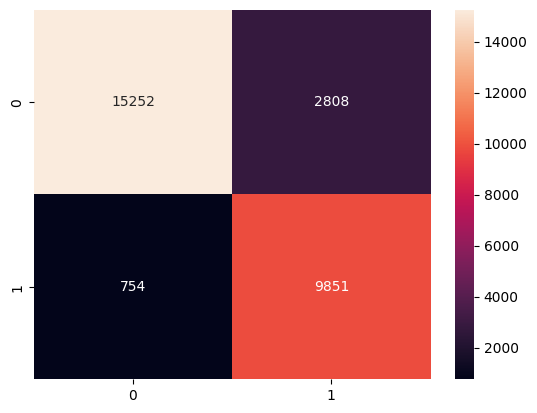

In [65]:
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.show()

# COMPLETE MODEL

In [66]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [73]:
model_name = "yamnet_augmentedwhole1"
saved_model_path = '/kaggle/working/{}'.format(model_name)
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

In [74]:
serving_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 audio (InputLayer)          [(None,)]                 0         
                                                                 
 yamnet (KerasLayer)         [(None, 521),             0         
                              (None, 1024),                      
                              (None, 64)]                        
                                                                 
 my_model (Sequential)       (None, 2)                 525826    
                                                                 
 classifier (ReduceMeanLayer  (2,)                     0         
 )                                                               
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_____________________________________________________

In [75]:
#Saving it as h5 
model_name = "yamnet_augmentedwhole1withoptimizer"
export_path_keras = "/kaggle/working/{}.h5".format(model_name)
print(export_path_keras)

serving_model.save(export_path_keras)

os.chdir('/kaggle/working')
FileLink('yamnet_augmentedwhole1withoptimizer.h5')

/kaggle/working/yamnet_augmentedwhole1withoptimizer.h5


/kaggle/working/yamnet_augmentedwhole1withoptimizer.h5

In [79]:
#Saving it as saved_model
export_path_sm = "/kaggle/working/wholw/saved_model/{}".format(model_name)
print(export_path_sm)

tf.saved_model.save(serving_model, export_path_sm)

!zip -r model1.zip {export_path_sm}

/kaggle/working/wholw/saved_model/yamnet_augmentedwhole1withoptimizer


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/wholw/saved_model/yamnet_augmentedwhole1withoptimizer/ (stored 0%)
  adding: kaggle/working/wholw/saved_model/yamnet_augmentedwhole1withoptimizer/saved_model.pb (deflated 91%)
  adding: kaggle/working/wholw/saved_model/yamnet_augmentedwhole1withoptimizer/fingerprint.pb (stored 0%)
  adding: kaggle/working/wholw/saved_model/yamnet_augmentedwhole1withoptimizer/assets/ (stored 0%)
  adding: kaggle/working/wholw/saved_model/yamnet_augmentedwhole1withoptimizer/assets/yamnet_class_map.csv (deflated 51%)
  adding: kaggle/working/wholw/saved_model/yamnet_augmentedwhole1withoptimizer/variables/ (stored 0%)
  adding: kaggle/working/wholw/saved_model/yamnet_augmentedwhole1withoptimizer/variables/variables.index (deflated 76%)
  adding: kaggle/working/wholw/saved_model/yamnet_augmentedwhole1withoptimizer/variables/variables.data-00000-of-00001 (deflated 10%)


In [84]:
FileLink('model1.zip')

/kaggle/working/model1.zip

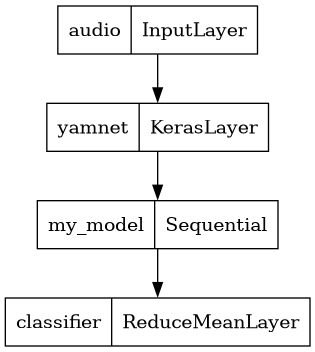

In [77]:
tf.keras.utils.plot_model(serving_model)

In [80]:
reloaded_model = tf.saved_model.load('/kaggle/working/wholw/saved_model/yamnet_augmentedwhole1withoptimizer')

In [81]:
reloaded_results = reloaded_model(testing_flac_data)
bonafide_or_spoof = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {bonafide_or_spoof}')

The main sound is: spoof


In [82]:
serving_results = reloaded_model.signatures['serving_default'](testing_flac_data)
bonafide_or_spoof = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {bonafide_or_spoof}')

The main sound is: spoof
